# Utilities

In [3]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import matplotlib as mpl
from scipy.integrate import odeint
from numpy import linalg as LA
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
mpl.rcdefaults() 
from scipy.stats import uniform
import scipy.stats as st
from matplotlib import colors
from matplotlib import cm
import pandas as pd
from scipy.stats import gaussian_kde

import datetime
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy
import multiprocessing as mp
import json
import xarray as xr
# from dask import delayed
import pickle
from scipy.stats import linregress
from EWS_functions import *
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

jtplot.style(context='paper', fscale=1.4, spines=True, grid=False, ticks=True,gridlines='--')
import itertools

fontsize=16
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize']= 'x-large'
mpl.rcParams['figure.facecolor']='white'

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
hfont = {'fontname':'Arial'}

mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']) 

In [4]:
indices = ['strn26','strn35','index']

In [5]:
ds = xr.open_dataset('CMIP6_amoc.nc')

strn26 = ds.strength_265N
strn35 = ds.strength_35N
index = ds.index

yrs = strn26.year.values
models = strn26.models.values
ensembs = strn26.ensemble_members.values

In [6]:
ds=xr.open_dataset('/p/tmp/mayayami/AR6/CMIP6_surr_lambdas10_full.nc')

In [7]:
np.where(ds.lams<-1)

(array([  0,   0,   0, ..., 999, 999, 999]),
 array([0, 0, 0, ..., 2, 2, 2]),
 array([ 3,  3,  3, ..., 17, 17, 17]),
 array([0, 0, 0, ..., 6, 8, 8]),
 array([ 57,  59,  60, ..., 100,  88,  89]))

# EWS

In [8]:
ds=xr.open_dataset('/p/tmp/mayayami/AR6/CMIP6_surr_metrics.nc')
surr_taus = ds.taus
surr_ps = ds.ps

In [9]:
amoc = xr.open_dataset('CMIP6_amoc2.nc').amoc

In [10]:
cmip_taus = xr.open_dataset('new_EWS/CMIP6_lam_tau_w50.nc').taus
cmip_ps = xr.open_dataset('new_EWS/CMIP6_lam_pvs_w50.nc').trends

In [11]:
model = 'CESM2'
iens = 2
indx = 'strn26'

model = 'CanESM5'
iens = 6
indx = 'strn26'
indx = 'strn35'
data = ds.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
# lam = 
ctau = cmip_taus.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
cp = cmip_ps.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


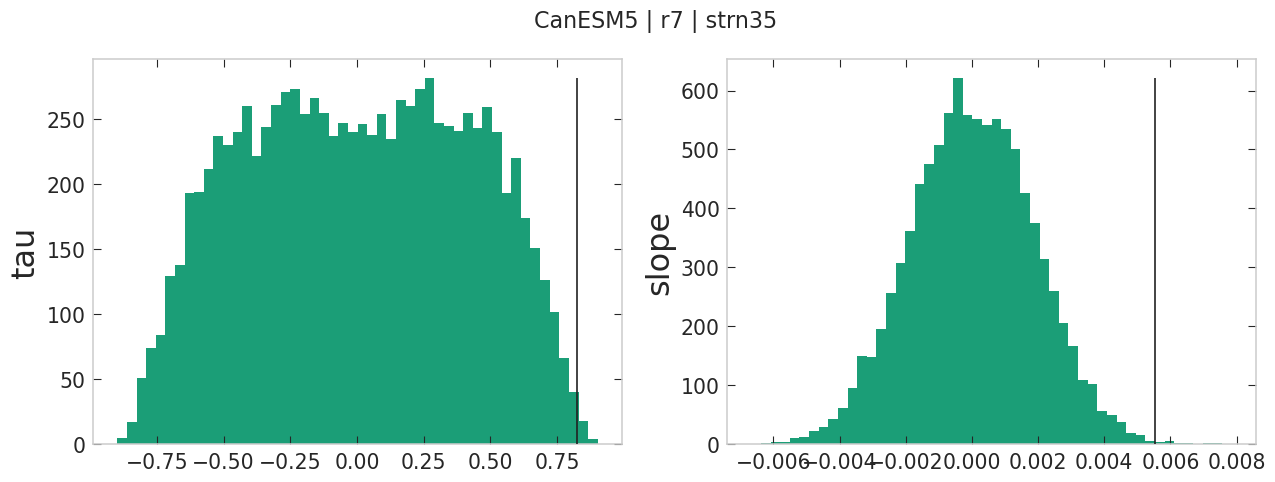

In [12]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
h = plt.hist(data.taus,bins=50)
plt.vlines(ctau,0,h[0].max(),color='k',zorder=20)
plt.ylabel('tau')
ax = fig.add_subplot(122)
h = plt.hist(data.ps,bins=50)
plt.ylabel('slope')
plt.vlines(cp,0,h[0].max(),color='k',zorder=20)
fig.suptitle('{} | r{} | {}'.format(model,iens+1,indx))
plt.show()

In [13]:
d = cmip_ps.expand_dims(dim='surrogates', axis=0)
parr = xr.concat((surr_ps,d),dim='surrogates') # the last value on the row is the cmip6 one

d = cmip_taus.expand_dims(dim='surrogates', axis=0)
tarr = xr.concat((surr_taus,d),dim='surrogates') # the last value on the row is the cmip6 one

In [14]:
def f(x):
    return st.percentileofscore(x, x[-1])

ppvs = 1- np.apply_along_axis(f, 0, parr)/100
tpvs = 1- np.apply_along_axis(f, 0, tarr)/100

In [15]:
def f2(x):
    return st.percentileofscore(x, x[0])

sppvs1 = 1- np.apply_along_axis(f2, 0, surr_ps)/100
stpvs1 = 1- np.apply_along_axis(f2, 0, surr_taus)/100

def f2(x):
    return st.percentileofscore(x, x[1])

sppvs2 = 1- np.apply_along_axis(f2, 0, surr_ps)/100
stpvs2 = 1- np.apply_along_axis(f2, 0, surr_taus)/100

In [16]:
idc = np.where((ppvs<=0.05) & (tpvs<=0.05))
for i, idx in enumerate(idc[0]):
    print('{} - {} - {}th ensemble member'.format(models[idc[1][i]],indices[idx],idc[2][i]))

MIROC6 - strn26 - 1th ensemble member
CanESM5 - strn35 - 6th ensemble member
CanESM5 - index - 9th ensemble member


In [17]:
idc = np.where(ppvs<=0.05)
for i, idx in enumerate(idc[0]):
    print('{} - {} - {}th'.format(models[idc[1][i]],indices[idx],idc[2][i],ppvs[idx,idc[1][i],idc[2][i]]))

CanESM5 - strn26 - 6th
MIROC6 - strn26 - 1th
MIROC6 - strn26 - 7th
CESM2 - strn26 - 0th
NESM3 - strn26 - 3th
CanESM5 - strn35 - 6th
HadGEM3-GC31-MM - strn35 - 0th
CESM2 - strn35 - 6th
CanESM5 - index - 9th


In [18]:
idc = np.where(tpvs<=0.05)
for i, idx in enumerate(idc[0]):
    print('{} - {} - {}th'.format(models[idc[1][i]],indices[idx],idc[2][i]))

MIROC6 - strn26 - 1th
MRI-ESM2-0 - strn26 - 0th
CanESM5 - strn35 - 6th
UKESM1-0-LL - strn35 - 4th
CanESM5 - index - 9th
INM-CM5-0 - index - 4th


In [19]:
lambdas = xr.open_dataset('new_EWS/CMIP6_lam_tau_w50.nc').lambdas

In [20]:
model = 'CanESM5'
iens = 6
indx = 'strn35'

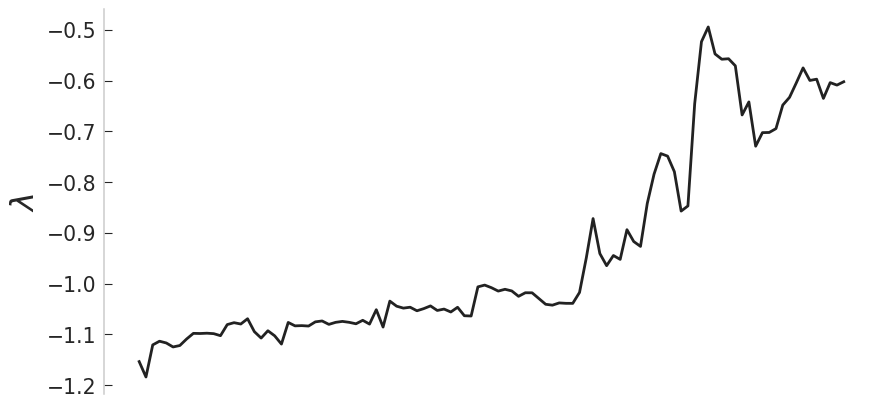

In [21]:

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
data = lambdas.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
plt.plot(data.values,lw=2,color='k')
plt.ylabel('$\lambda$')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('none')
ax.set_xticklabels([])
plt.show()

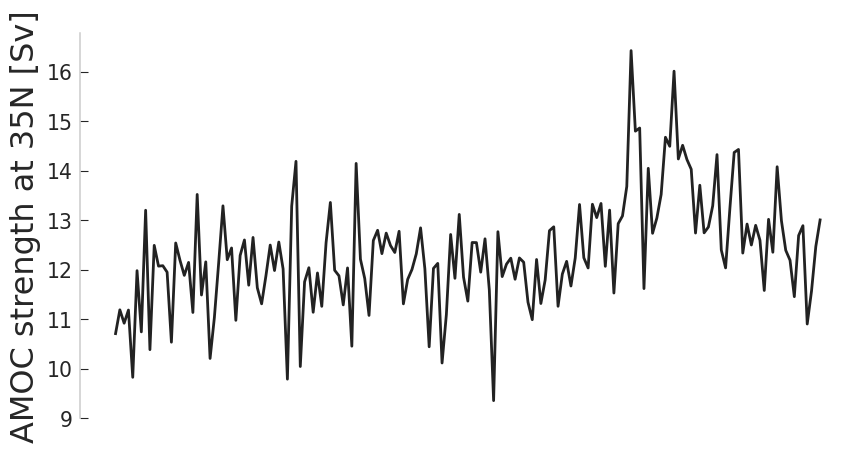

In [22]:

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
data = amoc.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
plt.plot(data.values,lw=2,color='k')
plt.ylabel('AMOC strength at 35N [Sv]')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('none')
ax.set_xticklabels([])
plt.show()

# compare

In [23]:
def slope_wrapper(lambd,time,ws=50):
    bound = ws // 2
    tt = time
    lam = np.nan_to_num(lambd)
    if lam.sum() != 0:
        p0, p1, r, p, se = st.linregress(tt,lam)
    else:
        p0 = np.nan
    return p0
def tau_wrapper(lambd,time,ws=50):
    bound = ws // 2
    tt = time[bound:-bound]
    lam = np.nan_to_num(lambd[bound : -bound])
    if lam.sum() != 0:
        tau = st.kendalltau(tt,lam)[0]
    else:
        tau = np.nan
    return tau

In [24]:
model = 'CESM2'
iens = 2
indx = 'strn26'

data = ds.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
lam = lambdas.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
ctau = cmip_taus.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
cp = cmip_ps.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)

In [25]:
ss = fourrier_surrogates(lam[25:-25],10000)

In [26]:
t = np.arange(1850,2014)[5:-5][25:-25]

In [27]:
ss_ps = np.full(10000,np.nan)
for i in range(10000):
    lm = ss[i]
    ss_ps[i]=slope_wrapper(lm,t)
ss_taus = np.full(10000,np.nan)
for i in range(10000):
    lm = ss[i]
    ss_taus[i]=tau_wrapper(lm,t)

In [1]:
def kde_plot(ax,xs,data,col='C0',lbl='',linestyle='-'):
    data = data[~np.isnan(data)]
    if data.sum()==0:
        ax.plot(xs,np.full_like(xs,0))
    else:
        density = gaussian_kde(data)
        density.covariance_factor = lambda : .25
        density._compute_covariance()
        ax.plot(xs,density(xs),color=col,label=lbl,lw=2,linestyle=linestyle)

## pv distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


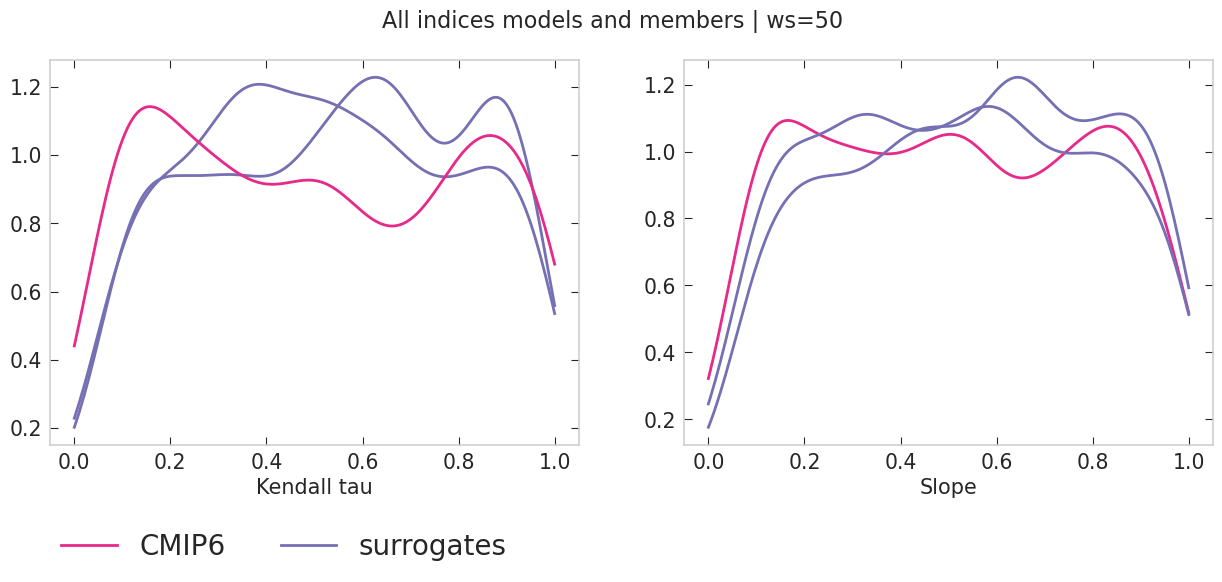

In [29]:

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
xs = np.linspace(0,1,200)
kde_plot(ax,xs,sppvs1.ravel(),col='C2')
kde_plot(ax,xs,sppvs2.ravel(),col='C2')
kde_plot(ax,xs,ppvs.ravel(),col='C3')
plt.xlabel('Kendall tau',fontsize=15)
ax = fig.add_subplot(122)
xs = np.linspace(0,1,200)
kde_plot(ax,xs,tpvs.ravel(),col='C3',lbl='CMIP6')
kde_plot(ax,xs,stpvs2.ravel(),col='C2')
kde_plot(ax,xs,stpvs1.ravel(),col='C2',lbl='surrogates')
plt.xlabel('Slope',fontsize=15)
fig.suptitle('All indices models and members | ws=50'.format(model,iens+1,indx))
ax.legend(bbox_to_anchor=(-1.2, -0.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=3)
plt.show()

## pre EWS surrogates

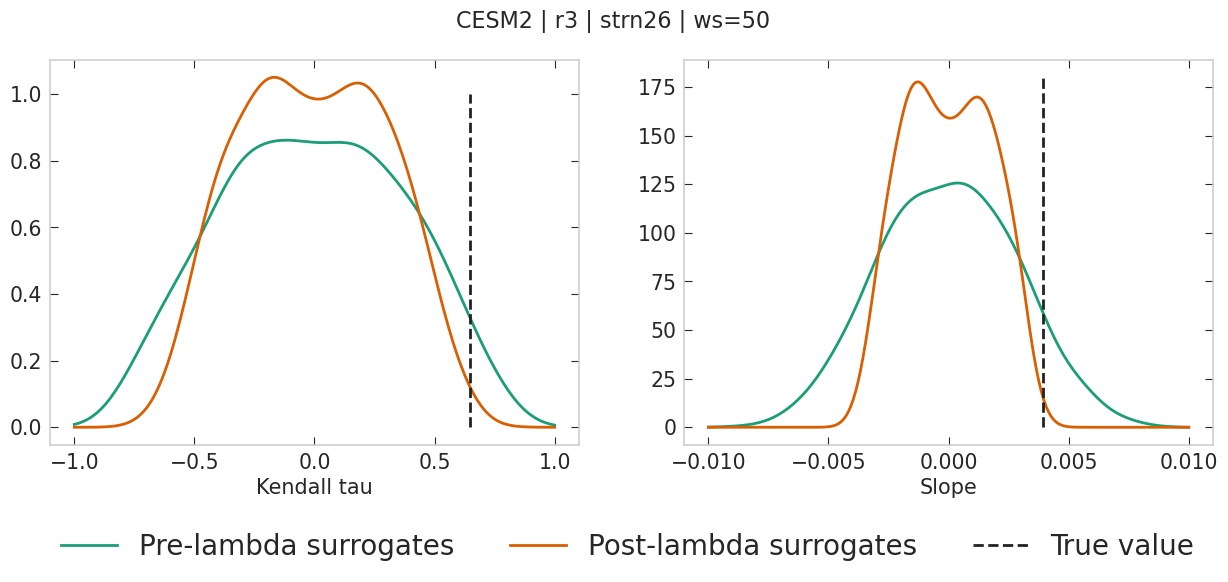

In [30]:
from scipy.stats import gaussian_kde


fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
xs = np.linspace(-1,1,200)
# h = plt.hist(data.taus,bins=20,density=True)
kde_plot(ax,xs,data.taus,col='C0')
kde_plot(ax,xs,ss_taus,col='C1')
plt.vlines(ctau,0,1,color='k',zorder=20,lw=2,linestyle='--')
plt.xlabel('Kendall tau',fontsize=15)
ax = fig.add_subplot(122)
xs = np.linspace(-0.01,0.01,200)
# h = plt.hist(data.ps,bins=50)
kde_plot(ax,xs,data.ps,col='C0',lbl='Pre-lambda surrogates')
plt.xlabel('Slope',fontsize=15)
kde_plot(ax,xs,ss_ps,col='C1',lbl='Post-lambda surrogates')
plt.vlines(cp,0,180,color='k',zorder=20,lw=2,linestyle='--',label='True value')
fig.suptitle('{} | r{} | {} | ws=50'.format(model,iens+1,indx))
ax.legend(bbox_to_anchor=(-1.2, -0.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=3)
plt.show()

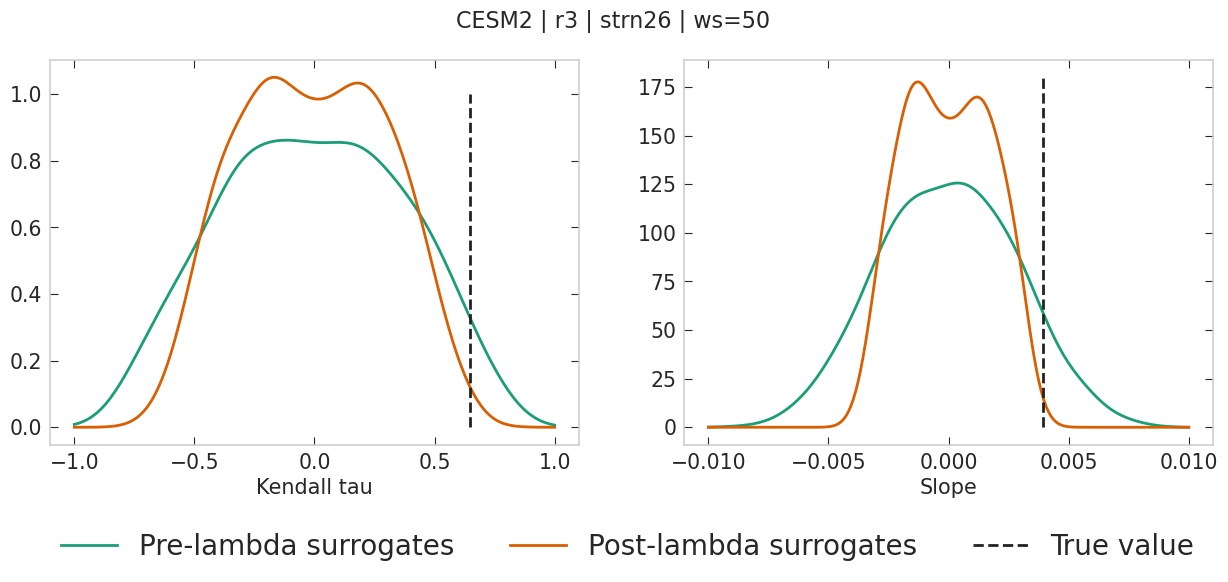

In [31]:
from scipy.stats import gaussian_kde


fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
xs = np.linspace(-1,1,200)
# h = plt.hist(data.taus,bins=20,density=True)
kde_plot(ax,xs,data.taus,col='C0')
kde_plot(ax,xs,ss_taus,col='C1')
# kde_plot(xs,cmip_taus.sel(indices='strn26').values.ravel(),col='k')
plt.vlines(ctau,0,1,color='k',zorder=20,lw=2,linestyle='--')
plt.xlabel('Kendall tau',fontsize=15)
ax = fig.add_subplot(122)
xs = np.linspace(-0.01,0.01,200)
# h = plt.hist(data.ps,bins=50)
kde_plot(ax,xs,data.ps,col='C0',lbl='Pre-lambda surrogates')
# kde_plot(xs,cmip_ps.sel(indices='strn26').values.ravel(),col='k')
plt.xlabel('Slope',fontsize=15)
kde_plot(ax,xs,ss_ps,col='C1',lbl='Post-lambda surrogates')
plt.vlines(cp,0,180,color='k',zorder=20,lw=2,linestyle='--',label='True value')
fig.suptitle('{} | r{} | {} | ws=50'.format(model,iens+1,indx))
ax.legend(bbox_to_anchor=(-1.2, -0.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=3)
plt.show()

## one model

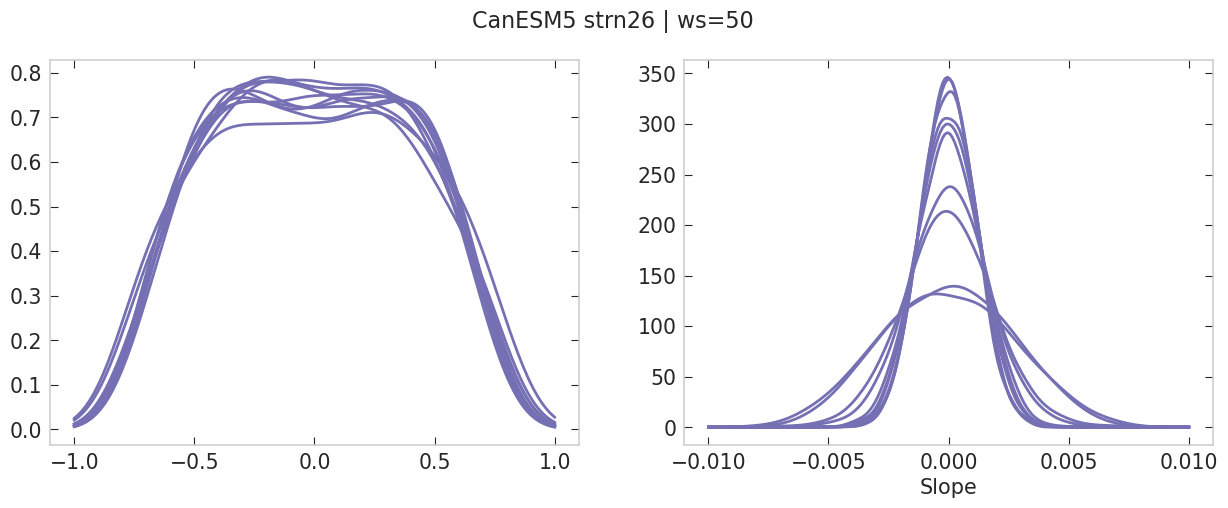

In [32]:
model='CanESM5'
indx = 'strn26'
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i in range(10):
    p = surr_ps.sel(models=model).values
    p = p[~np.isnan(p)]
    t = surr_taus.sel(models=model).values
    t = t[~np.isnan(t)]

    xs = np.linspace(-1,1,200)
#     ax1.hist(cmip_taus.sel(models=model).isel(ensemble_members=i).values.ravel(),color='C3',label='CMIP6',density=True,bins=10)
    kde_plot(ax1,xs,surr_taus.sel(indices=indx).sel(models=model).isel(ensemble_members=i).values.ravel(),col='C2')
    # kde_plot(xs,cmip_taus.sel(models=model).values.ravel(),col='C3')
    # plt.vlines(np.percentile(t,95),0,1,color='k',zorder=20,lw=2,linestyle='--')
    plt.xlabel('Kendall tau',fontsize=15)
    xs = np.linspace(-0.01,0.01,200)
    # kde_plot(xs,cmip_ps.sel(models=model).values.ravel(),col='C3',lbl='CMIP6')
#     ax2.hist(cmip_ps.sel(models=model).isel(ensemble_members=i).values.ravel(),color='C3',label='CMIP6',density=True,bins=10)
    kde_plot(ax2,xs,surr_ps.sel(indices=indx).sel(models=model).isel(ensemble_members=i).values.ravel(),col='C2',lbl='surrogates')
plt.xlabel('Slope',fontsize=15)
# plt.vlines(np.percentile(p,95),0,180,color='k',zorder=20,lw=2,linestyle='--',label='95th percentile')
fig.suptitle('{} {} | ws=50'.format(model,indx))
ax.legend(bbox_to_anchor=(-1.2, -0.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=3)
plt.show()

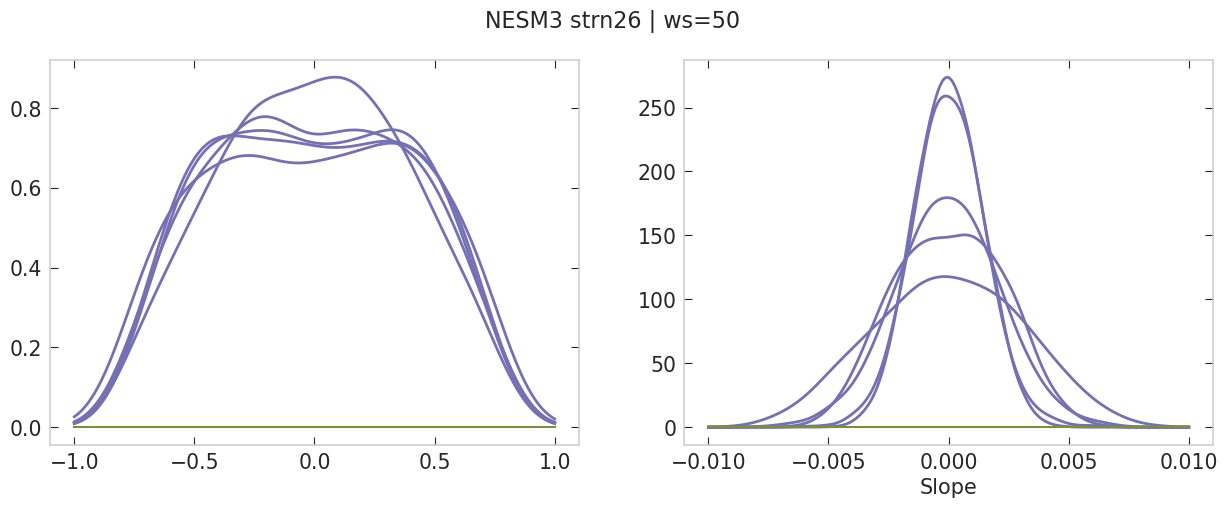

In [33]:
model='NESM3'
indx = 'strn26'
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i in range(10):
    p = surr_ps.sel(models=model).values
    p = p[~np.isnan(p)]
    t = surr_taus.sel(models=model).values
    t = t[~np.isnan(t)]

    xs = np.linspace(-1,1,200)
#     ax1.hist(cmip_taus.sel(models=model).isel(ensemble_members=i).values.ravel(),color='C3',label='CMIP6',density=True,bins=10)
    kde_plot(ax1,xs,surr_taus.sel(indices=indx).sel(models=model).isel(ensemble_members=i).values.ravel(),col='C2')
    # kde_plot(xs,cmip_taus.sel(models=model).values.ravel(),col='C3')
    # plt.vlines(np.percentile(t,95),0,1,color='k',zorder=20,lw=2,linestyle='--')
    plt.xlabel('Kendall tau',fontsize=15)
    xs = np.linspace(-0.01,0.01,200)
    # kde_plot(xs,cmip_ps.sel(models=model).values.ravel(),col='C3',lbl='CMIP6')
#     ax2.hist(cmip_ps.sel(models=model).isel(ensemble_members=i).values.ravel(),color='C3',label='CMIP6',density=True,bins=10)
    kde_plot(ax2,xs,surr_ps.sel(indices=indx).sel(models=model).isel(ensemble_members=i).values.ravel(),col='C2',lbl='surrogates')
plt.xlabel('Slope',fontsize=15)
# plt.vlines(np.percentile(p,95),0,180,color='k',zorder=20,lw=2,linestyle='--',label='95th percentile')
fig.suptitle('{} {} | ws=50'.format(model,indx))
ax.legend(bbox_to_anchor=(-1.2, -0.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=3)
plt.show()

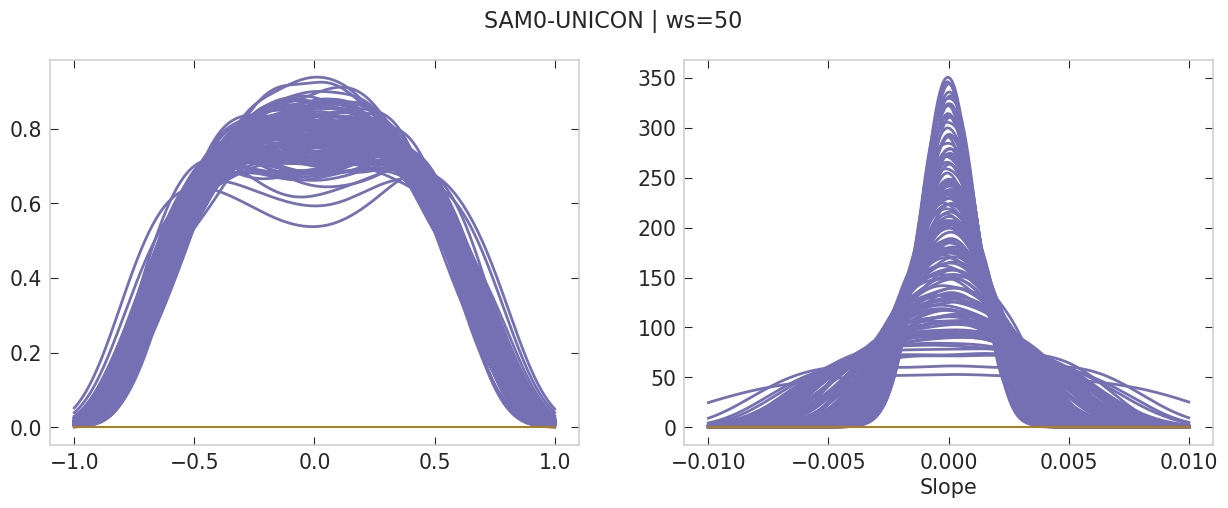

In [34]:
model='NESM3'
indx = 'strn26'
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for model in models:
    for i in range(10):
        p = surr_ps.sel(models=model).values
        p = p[~np.isnan(p)]
        t = surr_taus.sel(models=model).values
        t = t[~np.isnan(t)]

        xs = np.linspace(-1,1,200)
    #     ax1.hist(cmip_taus.sel(models=model).isel(ensemble_members=i).values.ravel(),color='C3',label='CMIP6',density=True,bins=10)
        kde_plot(ax1,xs,surr_taus.sel(indices=indx).sel(models=model).isel(ensemble_members=i).values.ravel(),col='C2')
        # kde_plot(xs,cmip_taus.sel(models=model).values.ravel(),col='C3')
        # plt.vlines(np.percentile(t,95),0,1,color='k',zorder=20,lw=2,linestyle='--')
        plt.xlabel('Kendall tau',fontsize=15)
        xs = np.linspace(-0.01,0.01,200)
        # kde_plot(xs,cmip_ps.sel(models=model).values.ravel(),col='C3',lbl='CMIP6')
    #     ax2.hist(cmip_ps.sel(models=model).isel(ensemble_members=i).values.ravel(),color='C3',label='CMIP6',density=True,bins=10)
        kde_plot(ax2,xs,surr_ps.sel(indices=indx).sel(models=model).isel(ensemble_members=i).values.ravel(),col='C2',lbl='surrogates')
plt.xlabel('Slope',fontsize=15)
# plt.vlines(np.percentile(p,95),0,180,color='k',zorder=20,lw=2,linestyle='--',label='95th percentile')
fig.suptitle('{} | ws=50'.format(model,indx))
ax.legend(bbox_to_anchor=(-1.2, -0.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=3)
plt.show()

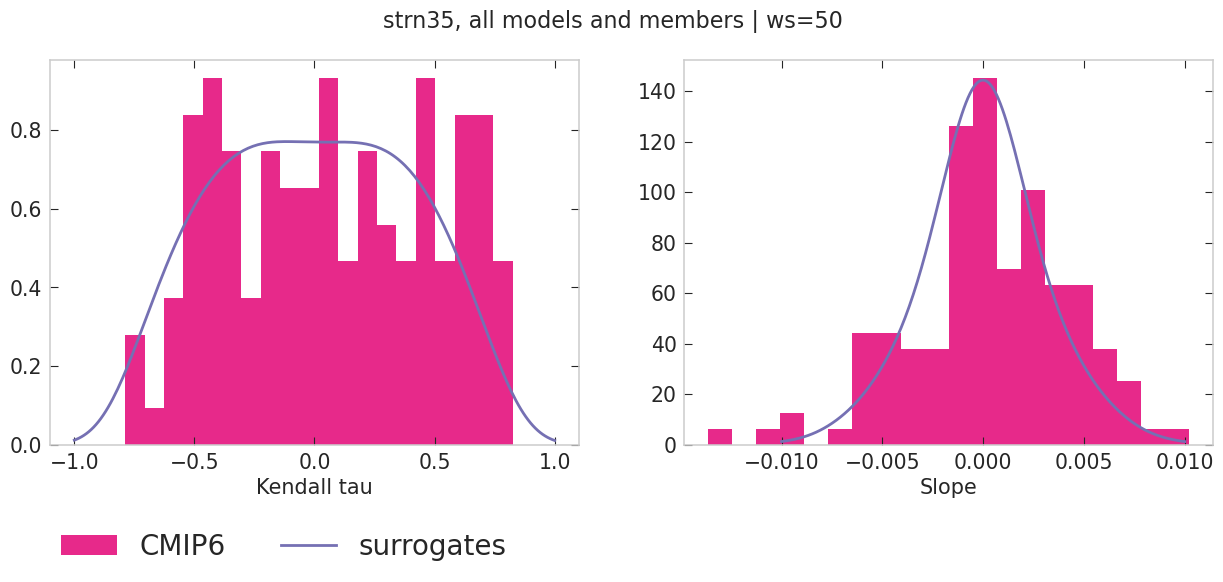

In [35]:
model='CESM2'
indx='strn35'
p = surr_ps.sel(models=model).values
p = p[~np.isnan(p)]
t = surr_taus.sel(models=model).values
t = t[~np.isnan(t)]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
xs = np.linspace(-1,1,200)
plt.hist(cmip_taus.sel(indices=indx).values.ravel(),color='C3',label='CMIP6',density=True,bins=20)
kde_plot(ax,xs,surr_taus.sel(indices=indx).values.ravel(),col='C2')
# kde_plot(xs,cmip_taus.sel(models=model).values.ravel(),col='C3')
# plt.vlines(np.percentile(t,95),0,1,color='k',zorder=20,lw=2,linestyle='--')
plt.xlabel('Kendall tau',fontsize=15)
ax = fig.add_subplot(122)
xs = np.linspace(-0.01,0.01,200)
# kde_plot(xs,cmip_ps.sel(models=model).values.ravel(),col='C3',lbl='CMIP6')
plt.hist(cmip_ps.sel(indices=indx).values.ravel(),color='C3',label='CMIP6',density=True,bins=20)
kde_plot(ax,xs,surr_ps.sel(indices=indx).values.ravel(),col='C2',lbl='surrogates')
plt.xlabel('Slope',fontsize=15)
# plt.vlines(np.percentile(p,95),0,180,color='k',zorder=20,lw=2,linestyle='--',label='95th percentile')
fig.suptitle('{}, all models and members | ws=50'.format(indx))
ax.legend(bbox_to_anchor=(-1.2, -0.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=3)
plt.show()

## total distributions

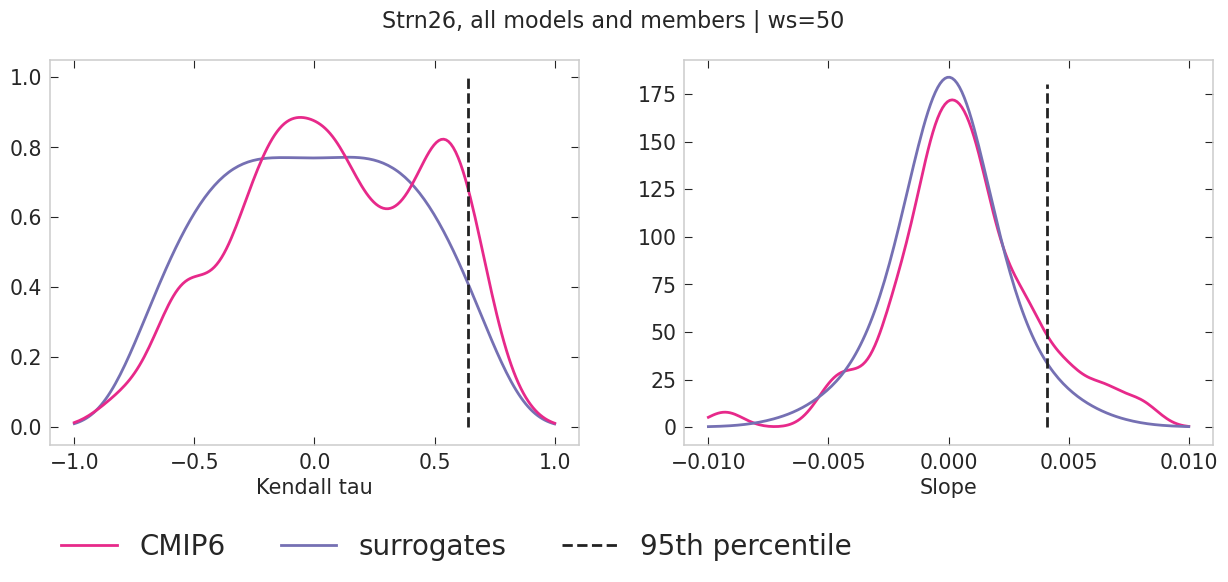

In [36]:
from scipy.stats import gaussian_kde
p = surr_ps.sel(indices='strn26').values
p = p[~np.isnan(p)]
t = surr_taus.sel(indices='strn26').values
t = t[~np.isnan(t)]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
xs = np.linspace(-1,1,200)
kde_plot(ax,xs,surr_taus.sel(indices='strn26').values.ravel(),col='C2')
kde_plot(ax,xs,cmip_taus.sel(indices='strn26').values.ravel(),col='C3')
plt.vlines(np.percentile(t,95),0,1,color='k',zorder=20,lw=2,linestyle='--')
plt.xlabel('Kendall tau',fontsize=15)
ax = fig.add_subplot(122)
xs = np.linspace(-0.01,0.01,200)
kde_plot(ax,xs,cmip_ps.sel(indices='strn26').values.ravel(),col='C3',lbl='CMIP6')
kde_plot(ax,xs,surr_ps.sel(indices='strn26').values.ravel(),col='C2',lbl='surrogates')
plt.xlabel('Slope',fontsize=15)
plt.vlines(np.percentile(p,95),0,180,color='k',zorder=20,lw=2,linestyle='--',label='95th percentile')
fig.suptitle('Strn26, all models and members | ws=50'.format(model,iens+1,indx))
ax.legend(bbox_to_anchor=(-1.2, -0.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=3)
plt.show()

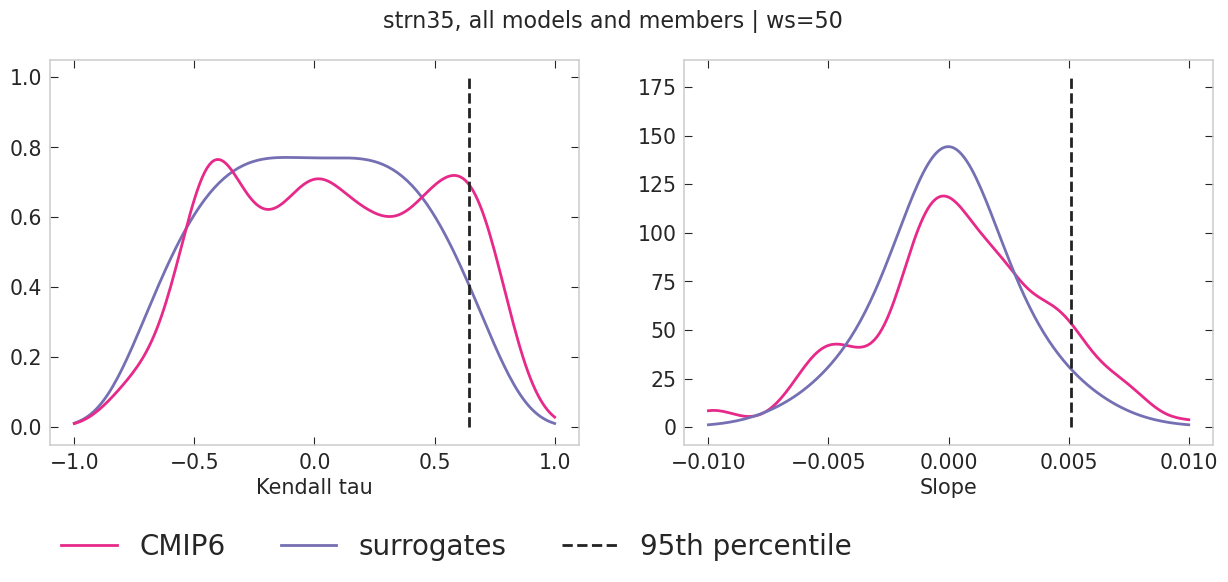

In [37]:
indx='strn35'
p = surr_ps.sel(indices=indx).values
p = p[~np.isnan(p)]
t = surr_taus.sel(indices=indx).values
t = t[~np.isnan(t)]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
xs = np.linspace(-1,1,200)
kde_plot(ax,xs,surr_taus.sel(indices=indx).values.ravel(),col='C2')
kde_plot(ax,xs,cmip_taus.sel(indices=indx).values.ravel(),col='C3')
plt.vlines(np.percentile(t,95),0,1,color='k',zorder=20,lw=2,linestyle='--')
plt.xlabel('Kendall tau',fontsize=15)
ax = fig.add_subplot(122)
xs = np.linspace(-0.01,0.01,200)
kde_plot(ax,xs,cmip_ps.sel(indices=indx).values.ravel(),col='C3',lbl='CMIP6')
kde_plot(ax,xs,surr_ps.sel(indices=indx).values.ravel(),col='C2',lbl='surrogates')
plt.xlabel('Slope',fontsize=15)
plt.vlines(np.percentile(p,95),0,180,color='k',zorder=20,lw=2,linestyle='--',label='95th percentile')
fig.suptitle('{}, all models and members | ws=50'.format(indx,model,iens+1,indx))
ax.legend(bbox_to_anchor=(-1.2, -0.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=3)
plt.show()

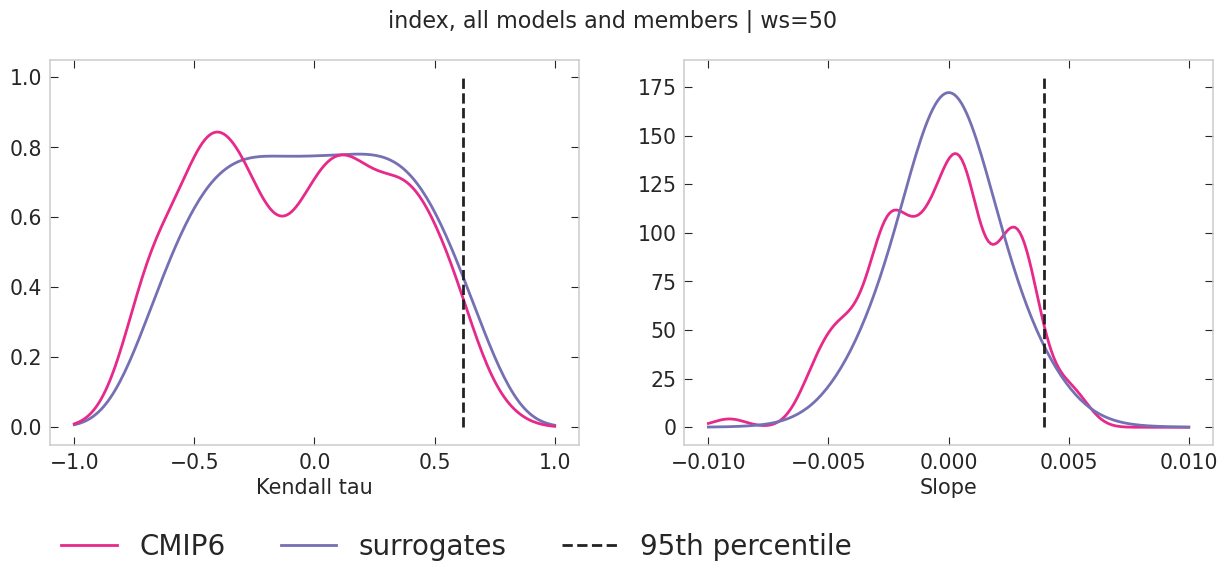

In [38]:
indx='index'
p = surr_ps.sel(indices=indx).values
p = p[~np.isnan(p)]
t = surr_taus.sel(indices=indx).values
t = t[~np.isnan(t)]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
xs = np.linspace(-1,1,200)
kde_plot(ax,xs,surr_taus.sel(indices=indx).values.ravel(),col='C2')
kde_plot(ax,xs,cmip_taus.sel(indices=indx).values.ravel(),col='C3')
plt.vlines(np.percentile(t,95),0,1,color='k',zorder=20,lw=2,linestyle='--')
plt.xlabel('Kendall tau',fontsize=15)
ax = fig.add_subplot(122)
xs = np.linspace(-0.01,0.01,200)
kde_plot(ax,xs,cmip_ps.sel(indices=indx).values.ravel(),col='C3',lbl='CMIP6')
kde_plot(ax,xs,surr_ps.sel(indices=indx).values.ravel(),col='C2',lbl='surrogates')
plt.xlabel('Slope',fontsize=15)
plt.vlines(np.percentile(p,95),0,180,color='k',zorder=20,lw=2,linestyle='--',label='95th percentile')
fig.suptitle('{}, all models and members | ws=50'.format(indx,model,iens+1,indx))
ax.legend(bbox_to_anchor=(-1.2, -0.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=3)
plt.show()

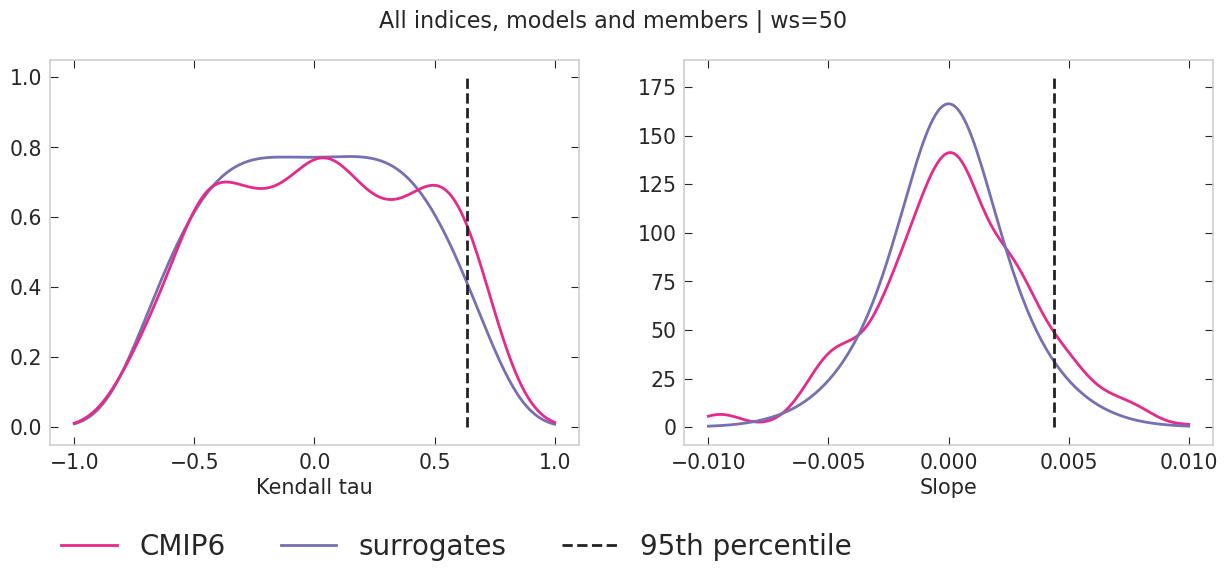

In [39]:
from scipy.stats import gaussian_kde
p = surr_ps.values
p = p[~np.isnan(p)]
t = surr_taus.values
t = t[~np.isnan(t)]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
xs = np.linspace(-1,1,200)
kde_plot(ax,xs,surr_taus.values.ravel(),col='C2')
kde_plot(ax,xs,cmip_taus.values.ravel(),col='C3')
plt.vlines(np.percentile(t,95),0,1,color='k',zorder=20,lw=2,linestyle='--')
plt.xlabel('Kendall tau',fontsize=15)
ax = fig.add_subplot(122)
xs = np.linspace(-0.01,0.01,200)
kde_plot(ax,xs,cmip_ps.values.ravel(),col='C3',lbl='CMIP6')
kde_plot(ax,xs,surr_ps.values.ravel(),col='C2',lbl='surrogates')
plt.xlabel('Slope',fontsize=15)
plt.vlines(np.percentile(p,95),0,180,color='k',zorder=20,lw=2,linestyle='--',label='95th percentile')
fig.suptitle('All indices, models and members | ws=50'.format(model,iens+1,indx))
ax.legend(bbox_to_anchor=(-1.2, -0.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=3)
plt.show()

# other window sizes

In [40]:
ds=xr.open_dataset('/p/tmp/mayayami/AR6/CMIP6_surr_metrics_w70.nc')
surr_taus70 = ds.taus
surr_ps70 = ds.ps

ds=xr.open_dataset('/p/tmp/mayayami/AR6/CMIP6_surr_metrics_w30.nc')
surr_taus30 = ds.taus
surr_ps30 = ds.ps

In [41]:
cmip_taus70 = xr.open_dataset('new_EWS/CMIP6_lam_tau_w70.nc').taus
cmip_ps70 = xr.open_dataset('new_EWS/CMIP6_lam_pvs_w70.nc').trends
cmip_taus30 = xr.open_dataset('new_EWS/CMIP6_lam_tau_w30.nc').taus
cmip_ps30 = xr.open_dataset('new_EWS/CMIP6_lam_pvs_w30.nc').trends

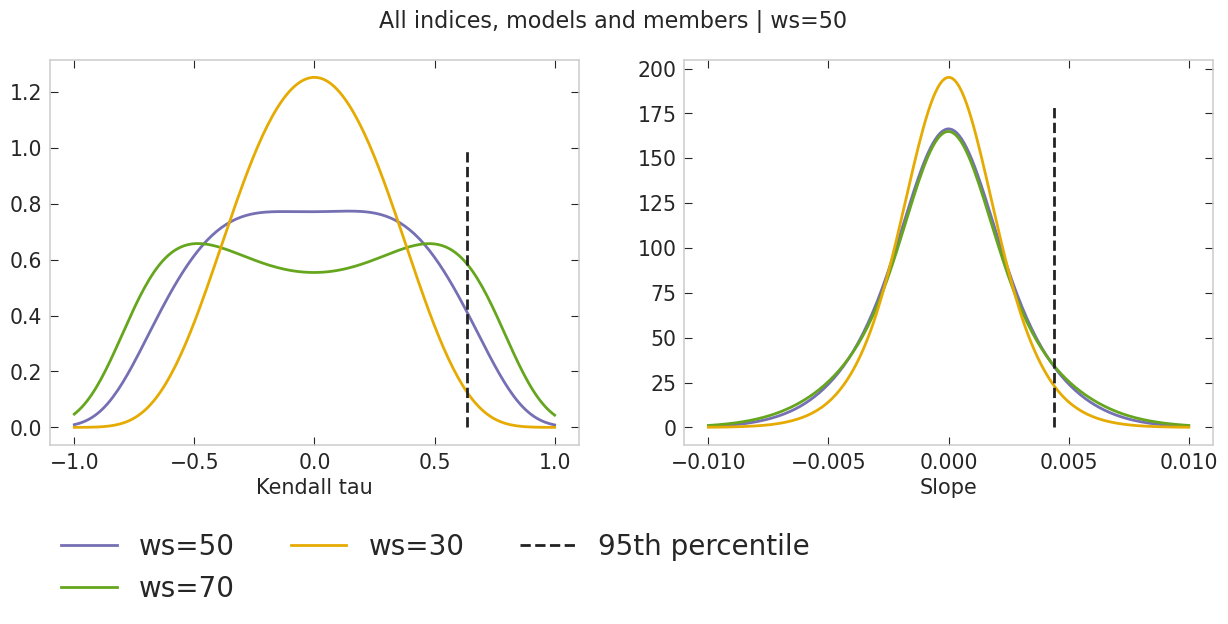

In [42]:
from scipy.stats import gaussian_kde
p = surr_ps.values
p = p[~np.isnan(p)]
t = surr_taus.values
t = t[~np.isnan(t)]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
xs = np.linspace(-1,1,200)
kde_plot(ax,xs,surr_taus.values.ravel(),col='C2')
kde_plot(ax,xs,surr_taus70.values.ravel(),col='C4')
kde_plot(ax,xs,surr_taus30.values.ravel(),col='C5')

# kde_plot(xs,cmip_taus.values.ravel(),col='C3')
plt.vlines(np.percentile(t,95),0,1,color='k',zorder=20,lw=2,linestyle='--')
plt.xlabel('Kendall tau',fontsize=15)
ax = fig.add_subplot(122)
xs = np.linspace(-0.01,0.01,200)
# kde_plot(xs,cmip_ps.values.ravel(),col='C3',lbl='CMIP6')
kde_plot(ax,xs,surr_ps.values.ravel(),col='C2',lbl='ws=50')
kde_plot(ax,xs,surr_ps70.values.ravel(),col='C4',lbl='ws=70')
kde_plot(ax,xs,surr_ps30.values.ravel(),col='C5',lbl='ws=30')

plt.xlabel('Slope',fontsize=15)
plt.vlines(np.percentile(p,95),0,180,color='k',zorder=20,lw=2,linestyle='--',label='95th percentile')
fig.suptitle('All indices, models and members | ws=50'.format(model,iens+1,indx))
ax.legend(bbox_to_anchor=(-1.2, -0.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=3)
plt.show()

In [43]:
d = cmip_ps70.expand_dims(dim='surrogates', axis=0)
parr70 = xr.concat((surr_ps,d),dim='surrogates') # the last value on the row is the cmip6 one

d = cmip_taus70.expand_dims(dim='surrogates', axis=0)
tarr70 = xr.concat((surr_taus,d),dim='surrogates') # the last value on the row is the cmip6 one

def f(x):
    return st.percentileofscore(x, x[-1])

ppvs70 = 1- np.apply_along_axis(f, 0, parr70)/100
tpvs70 = 1- np.apply_along_axis(f, 0, tarr70)/100

d = cmip_ps30.expand_dims(dim='surrogates', axis=0)
parr30 = xr.concat((surr_ps,d),dim='surrogates') # the last value on the row is the cmip6 one

d = cmip_taus30.expand_dims(dim='surrogates', axis=0)
tarr30 = xr.concat((surr_taus,d),dim='surrogates') # the last value on the row is the cmip6 one

def f(x):
    return st.percentileofscore(x, x[-1])

ppvs30 = 1- np.apply_along_axis(f, 0, parr30)/100
tpvs30 = 1- np.apply_along_axis(f, 0, tarr30)/100



In [44]:
idc = np.where((ppvs70<=0.05)&(ppvs<=0.05))
for i, idx in enumerate(idc[0]):
    print('{} - {} - {}th ensemble member'.format(models[idc[1][i]],indices[idx],idc[2][i]))

CanESM5 - strn26 - 6th ensemble member
MIROC6 - strn26 - 1th ensemble member
MIROC6 - strn26 - 7th ensemble member
NESM3 - strn26 - 3th ensemble member
CanESM5 - strn35 - 6th ensemble member
HadGEM3-GC31-MM - strn35 - 0th ensemble member
CESM2 - strn35 - 6th ensemble member


In [45]:
idc = np.where((ppvs70<=0.05))
for i, idx in enumerate(idc[0]):
    print('{} - {} - {}th ensemble member'.format(models[idc[1][i]],indices[idx],idc[2][i]))

CanESM5 - strn26 - 6th ensemble member
MIROC6 - strn26 - 1th ensemble member
MIROC6 - strn26 - 7th ensemble member
UKESM1-0-LL - strn26 - 5th ensemble member
CESM2-WACCM - strn26 - 0th ensemble member
NESM3 - strn26 - 3th ensemble member
CanESM5 - strn35 - 6th ensemble member
HadGEM3-GC31-MM - strn35 - 0th ensemble member
CESM2 - strn35 - 6th ensemble member
BCC-ESM1 - index - 2th ensemble member


In [46]:
idc = np.where((ppvs<=0.1))
for i, idx in enumerate(idc[0]):
    print('{} - {} - {}th ensemble member'.format(models[idc[1][i]],indices[idx],idc[2][i]))

CAMS-CSM1-0 - strn26 - 1th ensemble member
CanESM5 - strn26 - 6th ensemble member
CanESM5 - strn26 - 7th ensemble member
INM-CM5-0 - strn26 - 0th ensemble member
MIROC6 - strn26 - 1th ensemble member
MIROC6 - strn26 - 7th ensemble member
HadGEM3-GC31-LL - strn26 - 2th ensemble member
HadGEM3-GC31-LL - strn26 - 3th ensemble member
UKESM1-0-LL - strn26 - 5th ensemble member
MPI-ESM1-2-HR - strn26 - 6th ensemble member
MRI-ESM2-0 - strn26 - 0th ensemble member
CESM2 - strn26 - 0th ensemble member
CESM2 - strn26 - 5th ensemble member
CESM2 - strn26 - 7th ensemble member
CESM2-WACCM - strn26 - 0th ensemble member
NESM3 - strn26 - 3th ensemble member
CanESM5 - strn35 - 6th ensemble member
MIROC6 - strn35 - 4th ensemble member
MIROC6 - strn35 - 5th ensemble member
MIROC6 - strn35 - 7th ensemble member
HadGEM3-GC31-LL - strn35 - 2th ensemble member
HadGEM3-GC31-MM - strn35 - 0th ensemble member
HadGEM3-GC31-MM - strn35 - 1th ensemble member
UKESM1-0-LL - strn35 - 4th ensemble member
UKESM1-0-L

In [47]:
idc = np.where((ppvs<=0.05))
for i, idx in enumerate(idc[0]):
    print('{} - {} - {}th ensemble member'.format(models[idc[1][i]],indices[idx],idc[2][i]))

CanESM5 - strn26 - 6th ensemble member
MIROC6 - strn26 - 1th ensemble member
MIROC6 - strn26 - 7th ensemble member
CESM2 - strn26 - 0th ensemble member
NESM3 - strn26 - 3th ensemble member
CanESM5 - strn35 - 6th ensemble member
HadGEM3-GC31-MM - strn35 - 0th ensemble member
CESM2 - strn35 - 6th ensemble member
CanESM5 - index - 9th ensemble member


In [48]:
idc = np.where((tpvs70<=0.05)&(tpvs<=0.05))
for i, idx in enumerate(idc[0]):
    print('{} - {} - {}th ensemble member'.format(models[idc[1][i]],indices[idx],idc[2][i]))

MRI-ESM2-0 - strn26 - 0th ensemble member
CanESM5 - strn35 - 6th ensemble member
UKESM1-0-LL - strn35 - 4th ensemble member
CanESM5 - index - 9th ensemble member
INM-CM5-0 - index - 4th ensemble member


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


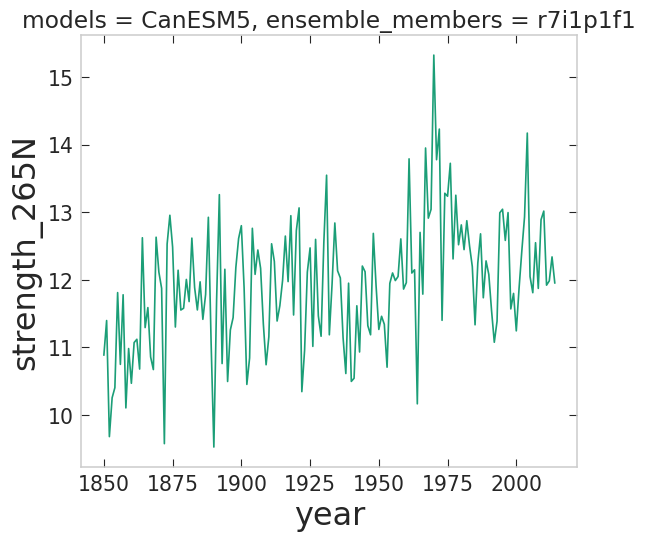

In [49]:
strn26.sel(models='CanESM5').isel(ensemble_members=6).plot()

# post-EWS

In [50]:
ds=xr.open_dataset('/p/tmp/mayayami/AR6/CMIP6_surr_metrics_postEWS.nc')
surr_taus_post = ds.taus
surr_ps_post = ds.ps

ds=xr.open_dataset('/p/tmp/mayayami/AR6/CMIP6_surr_metrics_postEWS_w70.nc')
surr_taus_post70 = ds.taus
surr_ps_post70 = ds.ps

ds=xr.open_dataset('/p/tmp/mayayami/CMIP6_surr_metrics_postEWS_w30.nc')
surr_taus_post30 = ds.taus
surr_ps_post30 = ds.ps

In [ ]:
from scipy.stats import gaussian_kde
p = surr_ps.values
p = p[~np.isnan(p)]
t = surr_taus.values
t = t[~np.isnan(t)]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
xs = np.linspace(-1,1,200)
kde_plot(ax,xs,surr_taus.values.ravel(),col='C2')
kde_plot(ax,xs,surr_taus_post.values.ravel(),col='C2',linestyle='--')
kde_plot(ax,xs,surr_taus70.values.ravel(),col='C4')
kde_plot(ax,xs,surr_taus_post70.values.ravel(),col='C4',linestyle='--')

kde_plot(ax,xs,surr_taus30.values.ravel(),col='C5')
kde_plot(ax,xs,surr_taus_post30.values.ravel(),col='C5',linestyle='--')

# kde_plot(xs,cmip_taus.values.ravel(),col='C3')
# plt.vlines(np.percentile(t,95),0,1,color='k',zorder=20,lw=2,linestyle='--')
plt.xlabel('Kendall tau',fontsize=15)
ax = fig.add_subplot(122)
xs = np.linspace(-0.01,0.01,200)
# kde_plot(xs,cmip_ps.values.ravel(),col='C3',lbl='CMIP6')
kde_plot(ax,xs,surr_ps.values.ravel(),col='C2',lbl='Pre-lambda surrogates, ws=50')
kde_plot(ax,xs,surr_ps_post.values.ravel(),col='C2',lbl='Post-lambda surrogates',linestyle='--')
kde_plot(ax,xs,surr_ps70.values.ravel(),col='C4',lbl='ws=70')
kde_plot(ax,xs,surr_ps_post70.values.ravel(),col='C4',linestyle='--')
kde_plot(ax,xs,surr_ps30.values.ravel(),col='C5',lbl='ws=30')
kde_plot(ax,xs,surr_ps_post30.values.ravel(),col='C5',linestyle='--')

plt.xlabel('Slope',fontsize=15)
# plt.vlines(np.percentile(p,95),0,180,color='k',zorder=20,lw=2,linestyle='--',label='95th percentile')
fig.suptitle('All indices, models and members | ws=50'.format(model,iens+1,indx))
ax.legend(bbox_to_anchor=(-1.2, -0.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
plt.show()

In [ ]:
def get(data):
    return data.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)

In [ ]:
model = 'CanESM5'
iens = 0
indx = 'strn26'
model = 'CESM2'
iens = 2
indx = 'strn26'

data = ds.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
ctau = cmip_taus.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
cp = cmip_ps.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
xs = np.linspace(-1,1,200)
# h = plt.hist(data.taus,bins=20,density=True)
kde_plot(ax,xs,get(surr_taus),col='C0')
kde_plot(ax,xs,get(surr_taus_post),col='C1')
# kde_plot(xs,cmip_taus.sel(indices='strn26').values.ravel(),col='k')
plt.vlines(ctau,0,1,color='k',zorder=20,lw=2,linestyle='--')
plt.xlabel('Kendall tau',fontsize=15)
ax = fig.add_subplot(122)
xs = np.linspace(-0.01,0.01,200)
# h = plt.hist(data.ps,bins=50)
kde_plot(ax,xs,get(surr_ps),col='C0',lbl='Pre-lambda surrogates')
# kde_plot(xs,cmip_ps.sel(indices='strn26').values.ravel(),col='k')
plt.xlabel('Slope',fontsize=15)
kde_plot(ax,xs,get(surr_ps_post),col='C1',lbl='Post-lambda surrogates')
plt.vlines(cp,0,180,color='k',zorder=20,lw=2,linestyle='--',label='True value')
fig.suptitle('{} | r{} | {} | ws=50'.format(model,iens+1,indx))
ax.legend(bbox_to_anchor=(-1.2, -0.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=3)
plt.show()

In [ ]:
model = 'CanESM5'
iens = 0
indx = 'strn26'
model = 'CanESM5'
iens = 6
indx = 'strn35'

data = ds.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
ctau = cmip_taus.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
cp = cmip_ps.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
xs = np.linspace(-1,1,200)
# h = plt.hist(data.taus,bins=20,density=True)
kde_plot(ax,xs,get(surr_taus),col='C0')
kde_plot(ax,xs,get(surr_taus_post),col='C1')
# kde_plot(xs,cmip_taus.sel(indices='strn26').values.ravel(),col='k')
plt.vlines(ctau,0,1,color='k',zorder=20,lw=2,linestyle='--')
plt.xlabel('Kendall tau',fontsize=15)
ax = fig.add_subplot(122)
xs = np.linspace(-0.01,0.01,200)
# h = plt.hist(data.ps,bins=50)
kde_plot(ax,xs,get(surr_ps),col='C0',lbl='Pre-lambda surrogates')
# kde_plot(xs,cmip_ps.sel(indices='strn26').values.ravel(),col='k')
plt.xlabel('Slope',fontsize=15)
kde_plot(ax,xs,get(surr_ps_post),col='C1',lbl='Post-lambda surrogates')
plt.vlines(cp,0,180,color='k',zorder=20,lw=2,linestyle='--',label='True value')
fig.suptitle('{} | r{} | {} | ws=50'.format(model,iens+1,indx))
ax.legend(bbox_to_anchor=(-1.2, -0.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=3)
plt.show()

In [ ]:
model = 'CanESM5'
model='CESM2'
iens = 0
indx = 'strn26'
ctau = cmip_taus.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
cp = cmip_ps.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
xs = np.linspace(-1.2,1.2,200)
kde_plot(ax,xs,get(surr_taus),col='C2',lbl='Pre-EWS surrogates')
kde_plot(ax,xs,get(surr_taus_post),col='C2',linestyle='--',lbl='Post-EWS surrogates')
kde_plot(ax,xs,get(surr_taus70),col='C4')
kde_plot(ax,xs,get(surr_taus_post70),col='C4',linestyle='--')

kde_plot(ax,xs,get(surr_taus30),col='C5')
kde_plot(ax,xs,get(surr_taus_post30),col='C5',linestyle='--')

plt.vlines(get(cmip_taus),0,1.3,color='C2',zorder=20,lw=2,linestyle='-')
plt.vlines(get(cmip_taus30),0,1.3,color='C5',zorder=20,lw=2,linestyle='-')
plt.vlines(get(cmip_taus70),0,1.3,color='C4',zorder=20,lw=2,linestyle='-')
ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=1)

# kde_plot(xs,cmip_taus),col='C3')
# plt.vlines(np.percentile(t,95),0,1,color='k',zorder=20,lw=2,linestyle='--')
plt.xlabel('Kendall tau',fontsize=15)
ax = fig.add_subplot(122)
xs = np.linspace(-0.01,0.01,200)
# kde_plot(xs,cmip_ps),col='C3',lbl='CMIP6')
kde_plot(ax,xs,get(surr_ps),col='C2',lbl='ws=50')
kde_plot(ax,xs,get(surr_ps_post),col='C2',linestyle='--')
kde_plot(ax,xs,get(surr_ps70),col='C4',lbl='ws=70')
kde_plot(ax,xs,get(surr_ps_post70),col='C4',linestyle='--')
kde_plot(ax,xs,get(surr_ps30),col='C5',lbl='ws=30')
kde_plot(ax,xs,get(surr_ps_post30),col='C5',linestyle='--')
plt.vlines(get(cmip_ps),0,260,color='C2',zorder=20,lw=2,linestyle='-')
plt.vlines(get(cmip_ps30),0,260,color='C5',zorder=20,lw=2,linestyle='-')
plt.vlines(get(cmip_ps70),0,260,color='C4',zorder=20,lw=2,linestyle='-')

plt.xlabel('Slope',fontsize=15)
# plt.vlines(np.percentile(p,95),0,180,color='k',zorder=20,lw=2,linestyle='--',label='95th percentile')
fig.suptitle('{} | r{} | {} | ws=50'.format(model,iens+1,indx))
ax.legend(bbox_to_anchor=(-0.4, -0.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=3)
plt.show()

# pv shading

In [ ]:
levels = [0] + list(np.logspace(np.log10(0.05),0,9))
colorss = ['white','#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b']
# colorss = ['white','#ffffe5','#fff7bc','#fee391','#fec44f','#fe9929','#ec7014','#cc4c02','#993404','#662506']

In [ ]:
radius_one = 0.3
# for modls in [models[0:12],models[12:22],models[22:]]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(nrows=6, ncols=6,height_ratios=(1,1,1,1,1,0.2))
ir = 0

for im, model in enumerate(models):
    idc = np.where(~np.isnan(cmip_taus.sel(indices='strn26').sel(models=model).values))
    n_tot = np.count_nonzero(~np.isnan(cmip_taus.sel(indices='strn26').sel(models=model).values))


    radius = 0.3+0.4*np.sqrt(n_tot)

    if n_tot!= 0:
        if ir<=5:
            ax = fig.add_subplot(gs[0,ir])
        if (ir>=6) & (ir<=11):
            ax = fig.add_subplot(gs[1,ir-6])
        if (ir>=12) & (ir<=17):
            ax = fig.add_subplot(gs[2,ir-12])
        if (ir>=18) & (ir<=23):
            ax = fig.add_subplot(gs[3,ir-18])
        if (ir>=24):
            ax = fig.add_subplot(gs[4,ir-24])

        ax.set_title('{} | {}'.format(model,n_tot),fontsize=14,fontweight='bold',y=1.1)
        
        rads = [1,0.7,0.4]
        
        for i in range(3):
            data = ppvs[i][im][idc]
            slices = np.full(len(data),1)
            cols = np.full(len(data),'lightgrey')
            for il, level in enumerate(levels[::-1]):
                idc2 = np.where(data<=level)
                cols[idc2]=colorss[il]
            patches, texts= ax.pie(
            slices,
                radius = rads[i]*radius,
            colors = cols,
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
            textprops={'size': 'x-large'})

        ir = ir +1
        
#         if ir==27:
#             ax.text(1.5,1,'Significantly\nincreasing $\lambda$ in:',transform=ax.transAxes,fontweight='bold',ma='left',color='k',fontsize=20)
#             ax.text(1.5,0.7,'Strn 26.5N',transform=ax.transAxes,fontweight='bold',ma='left',color='C0',fontsize=20)
#             ax.text(1.5,0.5,'Strn 35N',transform=ax.transAxes,fontweight='bold',ma='left',color='C2',fontsize=20)
#             ax.text(1.5,0.3,'SST Index',transform=ax.transAxes,fontweight='bold',ma='left',color='C3',fontsize=20)
cax = fig.add_subplot(gs[5,:])
cmap = mpl.colors.ListedColormap(colorss[::-1])
norm = mpl.colors.BoundaryNorm(levels, cmap.N)
mpl.colorbar.ColorbarBase(cax, cmap=cmap,ticks=levels,boundaries=levels,norm=norm,
                            orientation='horizontal',label='P-value of slope',extend='min')

fig.subplots_adjust(hspace=0.5)
#     fig.tight_layout()
fig.patch.set_facecolor("white")
plt.show()

In [ ]:
radius_one = 0.3
# for modls in [models[0:12],models[12:22],models[22:]]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(nrows=6, ncols=6,height_ratios=(1,1,1,1,1,0.2))
ir = 0

for im, model in enumerate(models):
    idc = np.where(~np.isnan(cmip_taus.sel(indices='strn26').sel(models=model).values))
    n_tot = np.count_nonzero(~np.isnan(cmip_taus.sel(indices='strn26').sel(models=model).values))


    radius = 0.3+0.4*np.sqrt(n_tot)

    if n_tot!= 0:
        if ir<=5:
            ax = fig.add_subplot(gs[0,ir])
        if (ir>=6) & (ir<=11):
            ax = fig.add_subplot(gs[1,ir-6])
        if (ir>=12) & (ir<=17):
            ax = fig.add_subplot(gs[2,ir-12])
        if (ir>=18) & (ir<=23):
            ax = fig.add_subplot(gs[3,ir-18])
        if (ir>=24):
            ax = fig.add_subplot(gs[4,ir-24])

        ax.set_title('{} | {}'.format(model,n_tot),fontsize=14,fontweight='bold',y=1.1)
        
        rads = [1,0.7,0.4]
        
        for i in range(3):
            data = tpvs[i][im][idc]
            slices = np.full(len(data),1)
            cols = np.full(len(data),'lightgrey')
            for il, level in enumerate(levels[::-1]):
                idc2 = np.where(data<=level)
                cols[idc2]=colorss[il]
            patches, texts= ax.pie(
            slices,
                radius = rads[i]*radius,
            colors = cols,
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
            textprops={'size': 'x-large'})

        ir = ir +1
        
#         if ir==27:
#             ax.text(1.5,1,'Significantly\nincreasing $\lambda$ in:',transform=ax.transAxes,fontweight='bold',ma='left',color='k',fontsize=20)
#             ax.text(1.5,0.7,'Strn 26.5N',transform=ax.transAxes,fontweight='bold',ma='left',color='C0',fontsize=20)
#             ax.text(1.5,0.5,'Strn 35N',transform=ax.transAxes,fontweight='bold',ma='left',color='C2',fontsize=20)
#             ax.text(1.5,0.3,'SST Index',transform=ax.transAxes,fontweight='bold',ma='left',color='C3',fontsize=20)
cax = fig.add_subplot(gs[5,:])
cmap = mpl.colors.ListedColormap(colorss[::-1])
norm = mpl.colors.BoundaryNorm(levels, cmap.N)
mpl.colorbar.ColorbarBase(cax, cmap=cmap,ticks=levels,boundaries=levels,norm=norm,
                            orientation='horizontal',label='P-value of kendall tau',extend='min')

fig.subplots_adjust(hspace=0.5)
#     fig.tight_layout()
fig.patch.set_facecolor("white")
plt.show()